In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [83]:
with open("../../corpus/NTT/persona.json", "r", encoding="utf-8") as f:
    convs = json.load(f)
all_utt = []
for did in tqdm( convs["convs"] ) :
    dids = list( did.keys() )[0]
    all_utt += did[dids]

with open("../../corpus/NTT/empathetic.json", "r", encoding="utf-8") as f:
    convs = json.load(f)
for did in tqdm( convs["convs"] ) :
    dids = list( did.keys() )[0]
    all_utt += did[dids]

100%|██████████| 19999/19999 [00:00<00:00, 1554750.25it/s]


In [88]:
# case_set = set("は　が　を　に　で")
case_set = set("は　が　を　に")
# case_set = set("が　を　に")
# def set_pair()
import copy
suit_base =  {
    "が": "[NONE]",
    "を": "[NONE]",
    "に": "[NONE]",
    "V" : ""
}

# def extract_RDF_triple(text, clean_=True):
def predicate_argument_structure_analysis(text, clean_=True):
    if clean_:
        text = clean_text(text)
    doc = nlp(text)
    triple_list = []
    suit_list = []
    for i, token in enumerate( doc ):
        if token.pos_ in ["VERB", "ADJ"]:
            # 受動表現の可能性があるものは回避
            if i<=len(doc)-2 and doc[i+1].pos_ == "AUX" and doc[i+1].lemma_ in ["れる", "られる"]:
                # print(doc)
                continue
            suit = copy.deepcopy(suit_base)
            suit["V"] = token.lemma_
            is_exist_case = False
            for c in token.children:
                if c.dep_ in ["nsubj", "obj", "obl"]:
                    noun = c.lemma_
                    
                    for c2 in c.children:
                        if c2.dep_ == "case" and c2.orth_ in case_set:
                            is_exist_case = True
                        # if c2.dep_ == "case":
                            case = c2.orth_
                            if case == "は":
                                case = "が"
                            triple_list.append( (noun, case, token.lemma_ ))
                            suit[case] = noun
            if is_exist_case:
                # print(suit)
                suit_list.append(suit)
             
    # return triple_list
    return suit_list

In [89]:
sentence = '麻生太郎は射撃が得意だ'
predicate_argument_structure_analysis(sentence)


[{'が': '射撃', 'を': '[NONE]', 'に': '[NONE]', 'V': '得意'}]

In [8]:
len(all_utt)

141777

In [38]:
suit_list = []
for utt in tqdm(all_utt[:300]):
    suit_list += predicate_argument_structure_analysis(utt)

100%|██████████| 300/300 [00:04<00:00, 65.43it/s]


In [90]:
import itertools

def triple_tuple(suit):
    if isinstance(suit, dict):
        return (suit["が"], suit["を"], suit["に"]), suit["V"]
    elif isinstance(suit, tuple):
        return (suit[0], suit[1], suit[2]), suit[3]
    else:
        return ()
    

def tuple_add_V2list(p, V):
    suit = list(p)
    suit.append(V)
    return suit

def tuple_add_V2tuple(p, V):
    return tuple(tuple_add_V2list(p, V))

def suit2list(suit):
    return list(suit.values())

def suit2tuple(suit):
    return tuple(suit.values())

def counterfeit_error(suit):
    base, V = triple_tuple(suit)
    # やっぱり [NONE] が 2つあるやつは無理！
    if list(base).count("[NONE]") == 2:
        return set()
    permutations = list( itertools.permutations(base, 3) )
    permutations.remove(base)
    suit_per = set(map(tuple_add_V2tuple, permutations, [V]*len(permutations) ))
    # return permutations
    return suit_per


In [65]:
# correct_suit = list(map(suit2list, suit_list ))
correct_suit_set = set(map(suit2tuple, suit_list ))

In [66]:
print(len(correct_suit_set))

299


In [77]:
error_suit_set = set()
for suit in tqdm(list(correct_suit_set)):
    error_suit_set |= counterfeit_error(suit)
    # print(counterfeit_error(suit))

100%|██████████| 299/299 [00:00<00:00, 542899.09it/s]


In [82]:
def predicate_argument_Xy(A):
    suit_list = []
    for utt in tqdm(A):
        suit_list += predicate_argument_structure_analysis(utt)
    
    correct_suit_set = set(map(suit2tuple, suit_list ))

    error_suit_set = set()
    for suit in tqdm(list(correct_suit_set)):
        error_suit_set |= counterfeit_error(suit)
    # 共通して含まれる要素は削除だ！
    correct_suit = list(correct_suit_set - error_suit_set)
    error_suit = list(error_suit_set-correct_suit_set)

    X_str = correct_suit + error_suit
    y = [0]*len(correct_suit) + [1]*len(error_suit)
    return X_str, y

In [14]:
from gensim.models import KeyedVectors

w2v_path = "../../corpus/w2v/"
# fasttext
# https://qiita.com/Hironsan/items/513b9f93752ecee9e670
w2v_name =  "dep-ja-300dim"
w2v_name =  "model.vec"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path+w2v_name)

[192] 2022-01-26 11:12:15,183 Info gensim.models.keyedvectors :loading projection weights from ../../corpus/w2v/model.vec
[192] 2022-01-26 11:13:17,143 Info gensim.utils :KeyedVectors lifecycle event {'msg': 'loaded (351122, 300) matrix of type float32 from ../../corpus/w2v/model.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-01-26T11:13:17.142675', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.72-microsoft-standard-WSL2-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}


In [96]:
X_str, y = predicate_argument_Xy(all_utt)

100%|██████████| 71007/71007 [00:00<00:00, 505548.93it/s]


In [97]:
len(set(X_str))

147640

In [98]:
wsv_dim = w2v_model["あ"].shape[0]
add_keys = ["FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]
add_weights = [np.random.randn(wsv_dim) for _ in range(len(add_keys))]
add_weights = [ v/np.linalg.norm(v) for v in add_weights ]
SYMBOL_w2v = dict(zip(add_keys, add_weights))

In [99]:
symbol_path = "../models/utterance/"
symbol_name = "caseframe_symbol2.pickle"
# symbol_name = "context_symbol_content.pickle"
symbolM = DataManager(symbol_path)
symbolM.save_data(symbol_name, SYMBOL_w2v)

success save : ../models/utterance/caseframe_symbol2.pickle


In [100]:
def w2v(word, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    # 形態素が登録されていたとき
    
    if word in SYMBOL_w2v:
        vector = SYMBOL_w2v[word]
    elif word in w2v_model:
        vector = w2v_model[word]
    else:
        vector = SYMBOL_w2v["[UNK]"]
    return vector


In [101]:
def make_X(X_str):
    X = []
    for suit in tqdm(X_str):
        vector = np.array([w2v(w, w2v_model, SYMBOL_w2v) for w in suit ]).flatten()
        X.append(vector)
    return np.array(X)

In [102]:
# X = make_X(X_str)

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [104]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [105]:
X_train_str, X_test_str, y_train, y_test = train_test_split(X_str, y, test_size=0.20, random_state=5)

In [106]:
X_train = torch.from_numpy( make_X(X_train_str) ) 
X_test = torch.from_numpy( make_X(X_test_str) ) 

100%|██████████| 29528/29528 [00:00<00:00, 94179.70it/s] 


In [107]:
len(X_train_str+X_test_str)

147640

- 前処理なしの大きさ
    - 258902

- set で前処理した大きさ
    - 147640

In [108]:
BATCH_SIZE = 64
epoch_ = 1000
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [109]:
class CaseFrameModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(CaseFrameModel, self).__init__()    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        # self.fb_dim = 4
        # self.fb_dim = 0
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        # self.hidden2tag = nn.Linear(self.hid2+self.fb_dim, tagset_size)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = F.relu(self.fc2(y))
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [110]:
EMBEDDING_DIM = 300*4
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 3
# seq_len = length
print(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

1200 2400 3


In [111]:
model = CaseFrameModel(EMBEDDING_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [113]:
losses = []
loss_border = 0.0001
for epoch in range(epoch_): 
    all_loss = 0
    for data in trainloader:
        X_t_tensor = data[0].cuda().float()
        y_t_tensor = data[1].cuda()
        optimizer.zero_grad()
        model.zero_grad()
        score_ = model(X_t_tensor)
        loss_ = loss_function(score_, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score_
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

epoch 50 	 loss 5.0481730881851945
epoch 100 	 loss 3.6757177023626184


KeyboardInterrupt: 

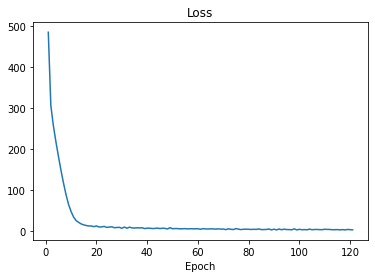

In [114]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")

    
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [115]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [116]:
def score(test, pred):
    if len(collections.Counter(pred)) <= 2:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))
        print('precision = ', precision_score(y_true=test, y_pred=pred))
        print('recall = ', recall_score(y_true=test, y_pred=pred))
        print('f1 score = ', f1_score(y_true=test, y_pred=pred))
    else:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))

In [117]:
score(y_test, y_pred)

confusion matrix = 
 [[12794  1018]
 [  565 15151]]
accuracy =  0.9463898672446491
precision =  0.9370400148432185
recall =  0.964049376431662
f1 score =  0.9503528304845539


In [118]:
model_path = "../models/caseframe/"
model_name = "CF_v2.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/caseframe/CF_v2.pickle
